In [41]:
from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph , START
from langgraph.types import Command
from typing_extensions import Literal
model = ChatOllama(model="llama3.2")
@tool
def ask_tax_advisor():
    """Use this tool to transfer the question to the Tax Advisor if investment advice needs tax clarification."""
    return "Passing to Tax Advisor"
@tool
def ask_finance_advisor():
    """Use this tool to transfer the question to the Finance Advisor if tax advice needs investment insight."""
    return "Passing to Finance Advisor"



In [42]:
# Finance Agent
def finance_advisor(state: MessagesState) -> Command[Literal["tax_advisor", "__end__"]]:
    system_prompt  = (
        
            "You are a Finance Advisor. Recommend investment strategies. "
            "If tax concerns arise, use the 'ask_tax_advisor' tool."
        )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([ask_tax_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="tax_advisor", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [43]:
# Tax Agent
def tax_advisor(state: MessagesState) -> Command[Literal["finance_advisor", "__end__"]]:
    system_prompt  = (
        
            "You are a Tax Advisor. Provide tax advice. "
            "If investment guidance is needed, use the 'ask_finance_advisor' tool."
        )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([ask_finance_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="finance_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [44]:
graph = StateGraph(MessagesState)
graph.add_node("finance_advisor", finance_advisor)
graph.add_node("tax_advisor", tax_advisor)
graph.add_edge(START,"finance_advisor")
app = graph.compile()

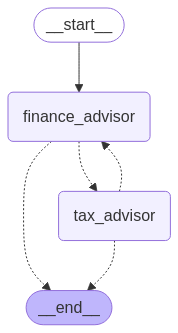

In [45]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [46]:
from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [48]:
for chunk in app.stream(
    {"messages": [("user", "suggests how to invest money")]}
):
    pretty_print_messages(chunk)

Update from node finance_advisor:


================================== Ai Message ==================================
Tool Calls:
  ask_tax_advisor (26f1c2b4-d934-46a9-8b95-db0225e2fc9e)
 Call ID: 26f1c2b4-d934-46a9-8b95-db0225e2fc9e
  Args:
================================= Tool Message =================================

Successfully transferred


Update from node tax_advisor:


================================== Ai Message ==================================
Tool Calls:
  ask_finance_advisor (53f6fd96-71ee-42a0-8304-6a18e7956729)
 Call ID: 53f6fd96-71ee-42a0-8304-6a18e7956729
  Args:
    amount: 10000
    risk_tolerance: medium
================================= Tool Message =================================

Successfully transferred


Update from node finance_advisor:


================================== Ai Message ==================================

Based on the input you provided, here is a suggested investment strategy:

**Investment Strategy:**

Considering your medium risk toleran